# Transfer learning for violence detection: an approach based on 2D CNNs and ConvLSTM (AIRTLab dataset)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/airtlab/violence-detection-tests-on-the-airtlab-dataset/blob/master/notebook/transfer-learning/Transfer_Learning_Violence_Detection_On_AIRTLab_Dataset_%282D_CNNs_ConvLSTM%29.ipynb)

This notebook contains the source code of the experiments presented in 
> P. Sernani, N. Falcionelli, S. Tomassini, P. Contardo and A.F. Dragoni, *Deep learning for automatic violence detection: tests on the AIRTLab dataset*.

a paper submitted for publication in the [IEEE Access](https://ieeeaccess.ieee.org/) journal.

Specifically, the experiments are **accuracy tests of five different 2D Convolutional Neural Networks (2D CNNs) pretrained on Imagenet**. The models are combined with a ConvLSTM layer. Such models perform a classification on samples of the **AIRTLab dataset**.

The dataset is publicly available in a dedicated GitHub repository: 
> <https://github.com/airtlab/A-Dataset-for-Automatic-Violence-Detection-in-Videos>

The tested 2D CNNs are:

- VGG16 ([https://keras.io/api/applications/vgg/#vgg16-function](https://keras.io/api/applications/vgg/#vgg16-function))
- VGG19 ([https://keras.io/api/applications/vgg/#vgg19-function](https://keras.io/api/applications/vgg/#vgg19-function))
- ResNet50V2 ([https://keras.io/api/applications/resnet/#resnet50v2-function](https://keras.io/api/applications/resnet/#resnet50v2-function))
- Xception ([https://keras.io/api/applications/xception/](https://keras.io/api/applications/xception/))
- NASNet Mobile ([https://keras.io/api/applications/nasnet/#nasnetmobile-function](https://keras.io/api/applications/nasnet/#nasnetmobile-function))

### Note

The results presented in the paper are computed with a **GPU runtime**. **5 randomized tests for each model** were performed, to generalize the performance of the proposed model. Due to the randomization of the dataset splitting and non-deterministic behaviour of GPU computation, the results can slightly change across different runs.

For more information about non-determism on GPU with TensorFlow check <https://github.com/NVIDIA/framework-determinism>.

## 1 Preliminary Operations
The following cells:
- **clone the AIRTLab** data repository into the /datarepo directory;
- define some utility functions to pre-process the dataset videos to get 16-frames chunks at a resolution of 224 x 224.

In [ ]:
# downloads the AIRTLAB dataset for violence detection
!mkdir /datarepo
!git clone https://github.com/airtlab/A-Dataset-for-Automatic-Violence-Detection-in-Videos.git /datarepo

Cloning into '/datarepo'...
remote: Enumerating objects: 373, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 373 (delta 2), reused 8 (delta 2), pack-reused 364
Receiving objects: 100% (373/373), 1.02 GiB | 41.74 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (355/355), done.


In [ ]:
# Utility functions for the experiments (chunk count, video preprocessing, feature computation, )
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

def count_chunks(videoBasePath):
    """Counts the 16 frames lenght chunks available in a dataset organized in violent and non-violent,
    cam1 and cam2 folders, placed at videoBasePath.

    Parameters
    ----------
    videoBasePath : str
                    Base path of the dataset

    Returns
    -------
    cnt : int
          number of 16 frames lenght chunks in the dataset
    """

    folders = ['violent', 'non-violent']
    cams = ['cam1', 'cam2']
    cnt = 0

    for folder in folders:
        for camName in cams:
            path = os.path.join(videoBasePath, folder, camName)

            videofiles = os.listdir(path)
            for videofile in videofiles:
                filePath = os.path.join(path, videofile)
                video = cv2.VideoCapture(filePath)
                numframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
                fps = int(video.get(cv2.CAP_PROP_FPS))
                chunks = numframes//16
                cnt += chunks
    

    return cnt

def preprocessVideos(videoBasePath, mainDir, featureBasePath, verbose=True):
    """Preproccess all the videos.

    It extracts samples from the videos organised in violent and non-violent, cam1 and cam2 folders.
    The samples and the labels are store on two memmap numpy arrays, called samples.mmap and labels.mmap, at "featureBasePath".
    The numpy array with samples has shape (Chunk #, 16, 224, 224, 3), the labels array has shape (Chunk # 16, 224, 224, 3).
    For the AIRTLab dataset the number of chunks is 3537.

    Parameters
    ----------
    videoBasePath : str
                    Pathname to the base of the video repository, which contains two directories,
                    violent and non-violent, which are divided into cam1 and cam2.
    mainDir: str
             Pathaname to store the files with sample filenames and labels.
    featureBasePath : str
                      it is the pathname of a base where the numpy arrays have to be saved.
    verbose : bool
              if True print debug logs (default True)
              
    """

    folders = ['violent', 'non-violent']
    cams = ['cam1', 'cam2']
    total_chunks = count_chunks(videoBasePath)
    fileNames = []
    npLabels = np.zeros(total_chunks)
    cnt = 0

    for folder in folders:
        for camName in cams:
            path = os.path.join(videoBasePath, folder, camName)

            videofiles = os.listdir(path)
            for videofile in videofiles:
                filePath = os.path.join(path, videofile)
                video = cv2.VideoCapture(filePath)
                numframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
                fps = int(video.get(cv2.CAP_PROP_FPS))
                chunks = numframes//16
                if verbose:
                    print(filePath)
                    print("*** [Video Info] Number of frames: {} - fps: {} - chunks: {}".format(numframes, fps, chunks))
                vid = []
                videoFrames = []
                while True:
                    ret, img = video.read()
                    if not ret:
                        break
                    videoFrames.append(cv2.resize(img, (224, 224)))
                vid = np.array(videoFrames, dtype=np.float32)
                filename = os.path.splitext(videofile)[0]
                chunk_cnt = 0
                for i in range(chunks):
                    X = vid[i*16:i*16+16]
                    chunk_cnt += 1
                    filename = folder + '_' + camName + '_' + videofile + '_chunk_' + str(chunk_cnt) + '.npy'
                    fileNames.append(filename)
                    savepath = os.path.join(featureBasePath, filename)
                    np.save(savepath, np.array(X, dtype=np.float32))
                    if folder == 'violent':
                        npLabels[cnt] = np.int8(1)
                    else:
                        npLabels[cnt] = np.int8(0)
                    cnt += 1

    fileNamesNp = os.path.join(mainDir, 'filenames.npy')
    np.save(fileNamesNp, fileNames)

    labelsNp = os.path.join(mainDir, 'labels.npy')
    np.save(labelsNp, npLabels)

    if verbose:
        print("** Labels **")
        print(npLabels.shape)
        print('\n****\n')
        print("** Samples **")
        print(len(fileNames))
        print('\n****\n')

    del fileNames
    del npLabels

## 2 Pre-processing
The following cells:
- create the folders to store the feature vectors extracted from the video chunks;
- execute the pre-processing on all the videos, transforming them into **16-frames** samples at a resolution of **224 x 224**.

In [ ]:
# folders to store samples and features during the experiments
!rm -rf airtlabDataset
!mkdir airtlabDataset
!mkdir airtlabDataset/features
!mkdir airtlabDataset/results

In [ ]:
#preprocessVideos('/datarepo/violence-detection-dataset', 'airtlabDataset', True)
preprocessVideos('/datarepo/violence-detection-dataset', 'airtlabDataset', 'airtlabDataset/features', True)

/datarepo/violence-detection-dataset/violent/cam1/80.mp4
*** [Video Info] Number of frames: 138 - fps: 30 - chunks: 8
/datarepo/violence-detection-dataset/violent/cam1/113.mp4
*** [Video Info] Number of frames: 192 - fps: 30 - chunks: 12
/datarepo/violence-detection-dataset/violent/cam1/65.mp4
*** [Video Info] Number of frames: 125 - fps: 30 - chunks: 7
/datarepo/violence-detection-dataset/violent/cam1/92.mp4
*** [Video Info] Number of frames: 170 - fps: 30 - chunks: 10
/datarepo/violence-detection-dataset/violent/cam1/93.mp4
*** [Video Info] Number of frames: 96 - fps: 30 - chunks: 6
/datarepo/violence-detection-dataset/violent/cam1/11.mp4
*** [Video Info] Number of frames: 132 - fps: 30 - chunks: 8
/datarepo/violence-detection-dataset/violent/cam1/64.mp4
*** [Video Info] Number of frames: 149 - fps: 30 - chunks: 9
/datarepo/violence-detection-dataset/violent/cam1/56.mp4
*** [Video Info] Number of frames: 159 - fps: 30 - chunks: 9
/datarepo/violence-detection-dataset/violent/cam1/86.m

## 3 Experiments

The following cells
- define some utilities functions to build the end-to-end models composed of 2D CNNs and ConvLSTM and to run the experiments on such models; the experiments are tests repeated **5 times** with the **stratified shuffle split** cross-validation scheme. In each split 80% of data are used for training, and 20% of data are used for testing. 12,5% of the training data (i.e. 10% of the entire dataset) is used for validation. In other words, in each test **70%** of data are actually for **training**, **10%** for **validation**, and **20%** for **testing**.
- run the experiments model by model.

Each tested model is composed according to the following table. Note that the weights of the **2D CNNs are the ImageNet weights**, whereas **the other layers are trained on the AIRTLab dataset**.

| Layer Type                                     | Output Shape         | Parameter # |
|:-----------------------------------------------|:---------------------|------------:|
| Time Distributed 2D CNN                        | -                    |      -            |
| ConvLSTM2D, *64 filters, 3x3*                  | (None, 15, 5, 64) |           - |
| Flatten                                        | (None, 1600)         |           0 |
| Dense, *256 units*, *ReLU activation*          | (None, 256)          |      409856 |
| Dropout, *0.5*                                 | (None, 256)          |           0 |
| Dense,  *1 unit*, *Sigmoid activation*         | (None, 1)            |         257 |


In [ ]:
# definitions of two end-to-end models + definitions of experiments
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pylab as plt
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, ConvLSTM2D, TimeDistributed, Bidirectional, LSTM
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.utils import Sequence

class DataGen(Sequence) :
    """ A sequence of data for training/test/validation, loaded from memory
    batch by batch. Extends the tensorflow.keras.utils.Sequence: https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence

    Attributes
    ----------
    base_path : str
                path to the folder including the samples.
    filenames : list<str>
                list of sample filenames.
    labels : list<str>
             list of sample labels.
    batch_size : int
                 batch size to load samples

    """
  
    def __init__(self, base_path, filenames, labels, batch_size) :
        self.base_path = base_path
        self.filenames = filenames
        self.labels = labels
        self.batch_size = batch_size
    
    
    def __len__(self) :
        return (np.ceil(len(self.filenames) / float(self.batch_size))).astype(np.int)
    
    
    def __getitem__(self, idx) :
        batch_x = self.filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        return np.array([np.load(os.path.join(self.base_path, file_name)) for file_name in batch_x]), np.array(batch_y)

def getVGG16Model(verbose=True):
    """Builds the VGG16 2D CNN, freezing its weights on ImageNet.

    Parameters
    ----------
    verbose : bool
              if True prints the model summary (default True)
    
    Returns
    -------
    vgg : Sequential
          The instantiated model
    """
    vgg = VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3));
    if verbose:
        vgg.summary()
    for layer in vgg.layers:
        layer.trainable = False;
    return vgg

def getVGG19Model(verbose=True):
    """Builds the VGG19 2D CNN, freezing its weights on ImageNet.

    Parameters
    ----------
    verbose : bool
              if True prints the model summary (default True)
    
    Returns
    -------
    vgg : Sequential
          The instantiated model
    """
    vgg = VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3));
    if verbose:
        vgg.summary()
    for layer in vgg.layers:
        layer.trainable = False;
    return vgg

def getResNet50V2Model(verbose=True):
    """Builds the ResNet50V2 2D CNN, freezing its weights on ImageNet.

    Parameters
    ----------
    verbose : bool
              if True prints the model summary (default True)
    
    Returns
    -------
    resnet : Sequential
             The instantiated model
    """
    resnet = ResNet50V2(include_top=False, weights="imagenet", input_shape=(224,224,3));
    if verbose:
        resnet.summary()
    for layer in resnet.layers:
        layer.trainable = False;
    return resnet

def getXceptionModel(verbose=True):
    """Builds the Xception 2D CNN, freezing its weights on ImageNet.

    Parameters
    ----------
    verbose : bool
              if True prints the model summary (default True)
    
    Returns
    -------
    xcep : Sequential
           The instantiated model
    """
    xcep = Xception(include_top=False, weights="imagenet", input_shape=(224,224,3));
    if verbose:
        xcep.summary()
    for layer in xcep.layers:
        layer.trainable = False;
    return xcep

def getNasnetModel(verbose=True):
    """Builds the NASNet Mobile 2D CNN, freezing its weights on ImageNet.

    Parameters
    ----------
    verbose : bool
              if True prints the model summary (default True)
    
    Returns
    -------
    nasn : Sequential
           The instantiated model
    """
    nasn = NASNetMobile(include_top=False, weights="imagenet", input_shape=(224,224,3));
    if verbose:
        nasn.summary()
    for layer in nasn.layers:
        layer.trainable = False;
    return nasn

def getInceptionResNetV2(verbose=True):
    """Builds the Inception-ResNetV2 2D CNN, freezing its weights on ImageNet.

    Parameters
    ----------
    verbose : bool
              if True prints the model summary (default True)
    
    Returns
    -------
    incres : Sequential
             The instantiated model
    """
    incres = InceptionResNetV2(include_top=False, weights="imagenet", input_shape=(224,224,3));
    if verbose:
        incres.summary()
    for layer in incres.layers:
        layer.trainable = False;
    return incres

def getLSTMModel(getConvModel, verbose=True):
    """Creates the model composed of a 2D CNN and ConvLSTM with the sequential
    API: https://keras.io/models/sequential/

    Parameters
    ----------
    getConvModel : Callable[[bool], Sequential]
                   Function that instantiates the Convolutional model to be applied
                   in a time distributed fashion. The parameter is a boolean
                   True for verbose output, False otherwise.
    verbose : bool
              if True prints the model summary (default True)

    Returns
    -------
    model : Sequential
            The instantiated model
    """
    model = Sequential()
    model.add(TimeDistributed(getConvModel(verbose), input_shape=(16,224,224,3)))

    model.add(ConvLSTM2D(filters=64, kernel_size=(3,3)))
    #model.add(TimeDistributed(Flatten()))
    #model.add(Bidirectional(LSTM(units=128, return_sequences=False)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    if verbose:
        model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def runEndToEndExperiment(getLSTMModel, getConvModel, batchSize, datasetBasePath, npyBasePath, featuresPath, samplesMMapName, lablesMMapName, endToEndModelName, rState):
    """"Runs the tests with end to end models.

    Parameters
    ----------
    getLSTMModel : Callable[Callable[[bool], Sequential][bool], Sequential]
                   Function that instantiates the model to be tested. The parameters 
                   are a function that returns the Convolutional model to be tested 
                   in a time distributed fashion, and a boolean for verbose output
    getConvModel : Callable[[bool], Sequential]
                   Function that instantiates the Convolutional model to be applied
                   in a time distributed fashion. The parameter is a boolean, pass
                   True for verbose output, false otherwise.
    batchSize : int
                Batch size to be used for training and testing
    datasetBasePath : str
                      Pathname to the base of the feature files repository,
                      which contains two directories, violent and non-violent,
                      which are divided into cam1 and cam2.
    npyBasePath : str
                  Pathaname where the files with sample filenames and labels are
                  stored.
    featuresPath : str
                  Folder containing the actual files with the samples.
    samplesMMapName : str
                      Name of the file storing the list with sample filenames.
    lablesMMapName : str
                     Name of the file storing the list of sample labels.
    endToEndModelName : str
                        Model name to be used in the AUC-ROC plot.
    rState : int, RandomState instance or None
             Controls the randomness of the training and testing indices produced.
             Pass an int for reproducible output across multiple function calls.
              
    """
    chunk_number = count_chunks(datasetBasePath)
    X = np.load(os.path.join(npyBasePath, samplesMMapName))
    y = np.load(os.path.join(npyBasePath, lablesMMapName))
    #X = np.memmap(os.path.join(mmapDatasetBasePath, samplesMMapName), mode='r', dtype=np.float32, shape=(chunk_number, 16, 224, 224, 3))
    #y = np.memmap(os.path.join(mmapDatasetBasePath, lablesMMapName), mode='r', dtype=np.int8, shape=(chunk_number))

    nsplits = 5
    cv = StratifiedShuffleSplit(n_splits=nsplits, train_size=0.8, random_state = rState)

    tprs = []
    aucs = []
    scores = []
    sens = np.zeros(shape=(nsplits))
    specs = np.zeros(shape=(nsplits))
    f1Scores = np.zeros(shape=(nsplits))
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(num=1, figsize=(10,10))
    i = 1

    for train, test in cv.split(X, y):

        #X_train = np.memmap(os.path.join(mmapDatasetBasePath, 'samples_train.mmap'), mode='w+', dtype=np.float32, shape=X[train].shape)
        #X_train[:] = X[train][:]
        X_train, X_val, y_train, y_val = train_test_split(X[train][:], y[train], test_size = 0.125, random_state = rState)

        #X_test = np.memmap(os.path.join(mmapDatasetBasePath, 'samples_test.mmap'), mode='w+', dtype=np.float32, shape=X[test].shape)
        #X_test[:] = X[test][:]

        filepath = os.path.join(npyBasePath, featuresPath)

        training_batch_generator = DataGen(filepath, X_train, y_train, batchSize)
        validation_batch_generator = DataGen(filepath, X_val, y_val, batchSize)
        test_batch_generator = DataGen(filepath, X[test][:], y[test], batchSize)

        #del X

        model = getLSTMModel(getConvModel, i==1)

        es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1, restore_best_weights=True)
        #model.fit(X_train, y[train], validation_split=0.125, epochs=50, batch_size=batchSize, verbose=1, callbacks=[es])
        model.fit(x=training_batch_generator, validation_data=validation_batch_generator, epochs=50, verbose=1, callbacks=[es])

        del X_train
        del X_val

        print("Computing scores...")
        #evaluation = model.evaluate(X_test, y[test])
        evaluation = model.evaluate(x=test_batch_generator)
        scores.append(evaluation)
        print("Computing probs...")
        #probas = model.predict(X_test, batch_size=batchSize, verbose=1).ravel()
        probas = model.predict(x=test_batch_generator, verbose=1).ravel()
        #del X_test

        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC split %d (AUC = %0.4f)' % (i, roc_auc))

        y_pred = np.round(probas)
        report = classification_report(y[test], y_pred, target_names=['non-violent', 'violent'], output_dict=True)
        sens[i - 1] = report['violent']['recall']
        specs[i - 1] = report['non-violent']['recall']
        f1Scores[i - 1] = report['violent']['f1-score']

        print('confusion matrix split ' + str(i))
        print(confusion_matrix(y[test], y_pred))
        print(classification_report(y[test], y_pred, target_names=['non-violent', 'violent']))
        print('Loss: ' + str(evaluation[0]))
        print('Accuracy: ' + str(evaluation[1]))
        print('\n')

        i += 1

        #X = np.memmap(os.path.join(mmapDatasetBasePath, samplesMMapName), mode='r', dtype=np.float32, shape=(chunk_number, 16, 224, 224, 3))
        del report
        del model

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Cross-Validation ROC of ' + endToEndModelName  + ' model',fontsize=18)
    plt.legend(loc="lower right", prop={'size': 15})

    #print(scores)
    np_scores = np.array(scores)
    losses = np_scores[:, 0:1]
    accuracies = np_scores[:, 1:2]
    print('Losses')
    print(losses)
    print('Accuracies')
    print(accuracies)
    print('Sensitivities')
    print(sens)
    print('specificities')
    print(specs)
    print('F1-scores')
    print(f1Scores)
    print("Avg loss: {0} +/- {1}".format(np.mean(losses), np.std(losses)))
    print("Avg accuracy: {0} +/- {1}".format(np.mean(accuracies), np.std(accuracies)))
    print("Avg sensitivity: {0} +/- {1}".format(np.mean(sens), np.std(sens)))
    print("Avg specificity: {0} +/- {1}".format(np.mean(specs), np.std(specs)))
    print("Avg f1-score: {0} +/- {1}".format(np.mean(f1Scores), np.std(f1Scores)))

    plt.savefig(endToEndModelName.replace('+', '') + '.pdf')
    plt.show()
  


    del X
    del y
    del sens
    del specs
    del f1Scores
    del accuracies
    del losses
    del np_scores


58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

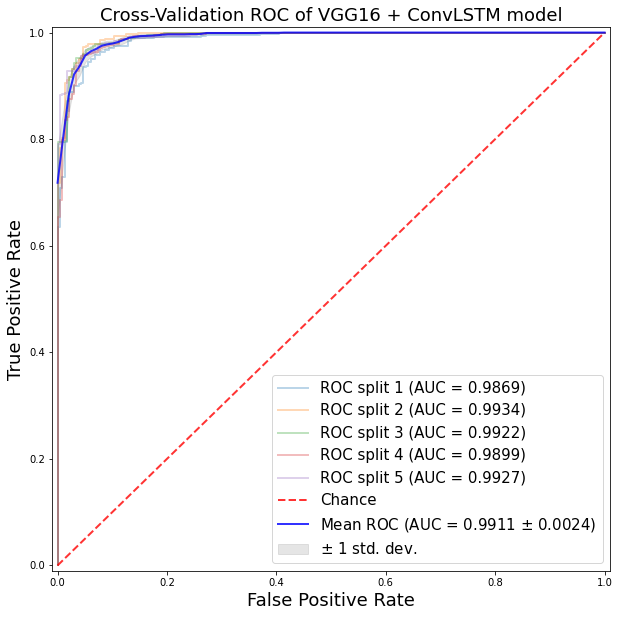

In [ ]:
# Experiment 1: VGG16 + ConvLSTM
runEndToEndExperiment(getLSTMModel, getVGG16Model, 8, '/datarepo/violence-detection-dataset', 'airtlabDataset', 'features', 'filenames.npy', 'labels.npy', 'VGG16 + ConvLSTM', 42)

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

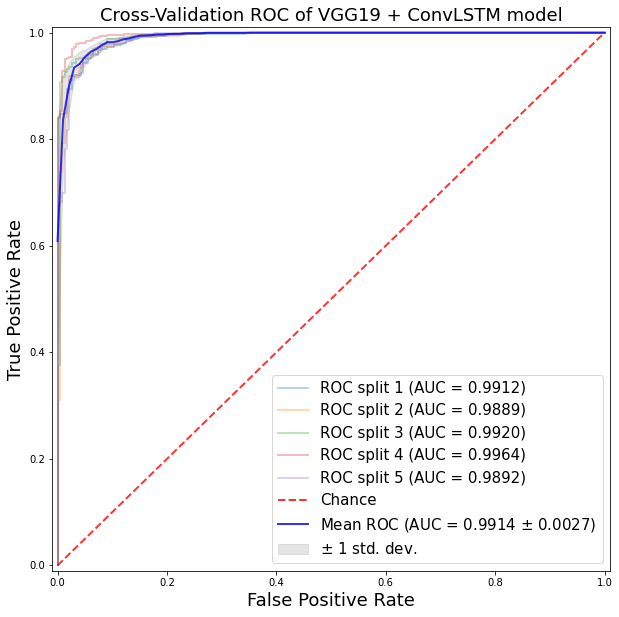

In [ ]:
# Experiment 2: VGG19 + ConvLSTM
runEndToEndExperiment(getLSTMModel, getVGG19Model, 8, '/datarepo/violence-detection-dataset', 'airtlabDataset', 'features', 'filenames.npy', 'labels.npy', 'VGG19 + ConvLSTM', 42)

94674944/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
310/310 [==============================] - 309s 979ms/step - loss: 0.6696 - accuracy: 0.6485 - val_loss: 0.6317 - val_accuracy: 0.6836
Epoch 2/50
310/310 [==============================] - 327s 1s/step - loss: 0.6480 - accuracy: 0.6703 - val_loss: 0.6355 - val_accuracy: 0.6836
Epoch 3/50
310/310 [==============================] - 328s 1s/step - loss: 0.6465 - accuracy: 0.6707 - val_loss: 0.6363 - val_accuracy: 0.6836
Epoch 4/50
310/310 [==============================] - 326s 1s/step - loss: 0.6439 - accuracy: 0.6707 - val_loss: 0.6289 - val_accuracy: 0.6836
Epoch 5/50
310/310 [==============================] - 325s 1s/step - loss: 0.6412 - accuracy: 0.6707 - val_loss: 0.6259 - val_accuracy: 0.6836
Epoch 6/50
310/310 [==============================] - 324s 1s/step - loss: 0.6432 - accuracy: 0.6707 - val_loss: 0.6248 - val_accuracy: 0.6836
Epoch 7/50
310/310 [==============================] - 328s 1s/step - loss: 0.6388 - accuracy: 0.6707 - val_loss: 0.6302 - val_accuracy: 0.6

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
310/310 [==============================] - 296s 934ms/step - loss: 0.6742 - accuracy: 0.6509 - val_loss: 0.6315 - val_accuracy: 0.6864
Epoch 2/50
310/310 [==============================] - 328s 1s/step - loss: 0.6498 - accuracy: 0.6703 - val_loss: 0.6338 - val_accuracy: 0.6864
Epoch 3/50
310/310 [==============================] - 321s 1s/step - loss: 0.6473 - accuracy: 0.6703 - val_loss: 0.6372 - val_accuracy: 0.6864
Epoch 4/50
310/310 [==============================] - 332s 1s/step - loss: 0.6442 - accuracy: 0.6703 - val_loss: 0.6314 - val_accuracy: 0.6864
Epoch 5/50
310/310 [==============================] - 331s 1s/step - loss: 0.6431 - accuracy: 0.6703 - val_loss: 0.6220 - val_accuracy: 0.6864
Epoch 6/50
310/310 [==============================] - 329s 1s/step - loss: 0.6406 - accuracy: 0.6703 - val_loss: 0.6236 - val_accuracy: 0.6864
Epoch 7/50
310/310 [==============================] - 324s 1s/step - loss: 0.6398 - accuracy: 0.6703 - val_loss: 0.6289 - val_accuracy: 0.6

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
310/310 [==============================] - 299s 948ms/step - loss: 0.6665 - accuracy: 0.6509 - val_loss: 0.6447 - val_accuracy: 0.6610
Epoch 2/50
310/310 [==============================] - 326s 1s/step - loss: 0.6393 - accuracy: 0.6739 - val_loss: 0.6502 - val_accuracy: 0.6610
Epoch 3/50
310/310 [==============================] - 319s 1s/step - loss: 0.6463 - accuracy: 0.6739 - val_loss: 0.6563 - val_accuracy: 0.6610
Epoch 4/50
310/310 [==============================] - 327s 1s/step - loss: 0.6426 - accuracy: 0.6739 - val_loss: 0.6418 - val_accuracy: 0.6610
Epoch 5/50
310/310 [==============================] - 329s 1s/step - loss: 0.6393 - accuracy: 0.6739 - val_loss: 0.6404 - val_accuracy: 0.6610
Epoch 6/50
310/310 [==============================] - 321s 1s/step - loss: 0.6378 - accuracy: 0.6739 - val_loss: 0.6412 - val_accuracy: 0.6610
Epoch 7/50
310/310 [==============================] - 337s 1s/step - loss: 0.6356 - accuracy: 0.6739 - val_loss: 0.6434 - val_accuracy: 0.6

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
310/310 [==============================] - 305s 962ms/step - loss: 0.6871 - accuracy: 0.6404 - val_loss: 0.6035 - val_accuracy: 0.7232
Epoch 2/50
310/310 [==============================] - 322s 1s/step - loss: 0.6490 - accuracy: 0.6651 - val_loss: 0.6123 - val_accuracy: 0.7232
Epoch 3/50
310/310 [==============================] - 312s 1s/step - loss: 0.6482 - accuracy: 0.6651 - val_loss: 0.6057 - val_accuracy: 0.7232
Epoch 4/50
310/310 [==============================] - 330s 1s/step - loss: 0.6493 - accuracy: 0.6651 - val_loss: 0.6126 - val_accuracy: 0.7232
Epoch 5/50
310/310 [==============================] - 320s 1s/step - loss: 0.6461 - accuracy: 0.6651 - val_loss: 0.6155 - val_accuracy: 0.7232
Epoch 6/50
310/310 [==============================] - 324s 1s/step - loss: 0.6454 - accuracy: 0.6651 - val_loss: 0.6095 - val_accuracy: 0.7232
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping
Computing scores...
89/89 [============================

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


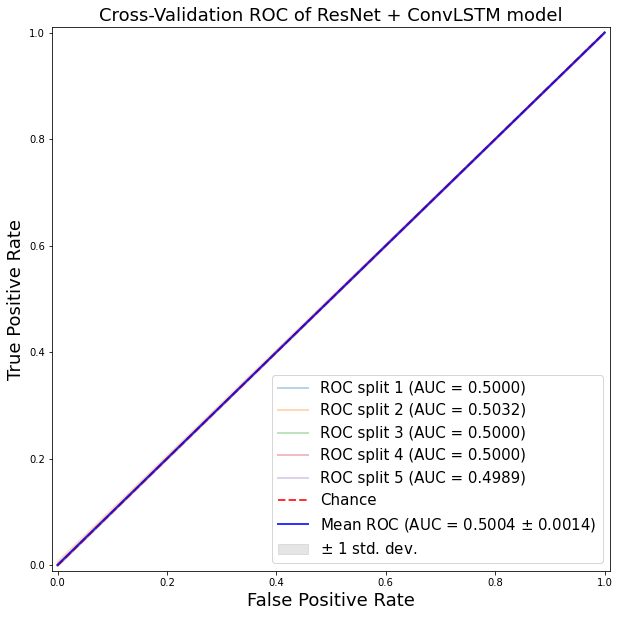

In [ ]:
# Experiment 3: ResNet50V2 + ConvLSTM
runEndToEndExperiment(getLSTMModel, getResNet50V2Model, 8, '/datarepo/violence-detection-dataset', 'airtlabDataset', 'features', 'filenames.npy', 'labels.npy', 'ResNet + ConvLSTM', 42)

83689472/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________

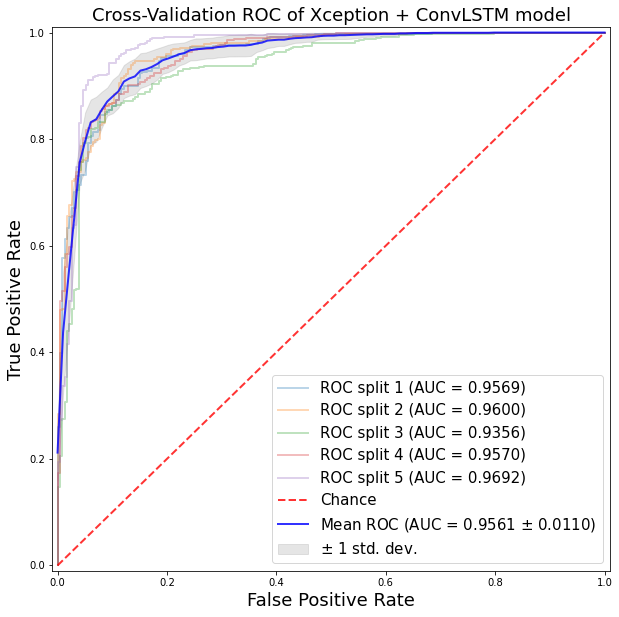

In [ ]:
# Experiment 4: Xception + ConvLSTM
runEndToEndExperiment(getLSTMModel, getXceptionModel, 8, '/datarepo/violence-detection-dataset', 'airtlabDataset', 'features', 'filenames.npy', 'labels.npy', 'Xception + ConvLSTM', 42)

19996672/19993432 [==============================] - 0s 0us/step
Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
____________________________

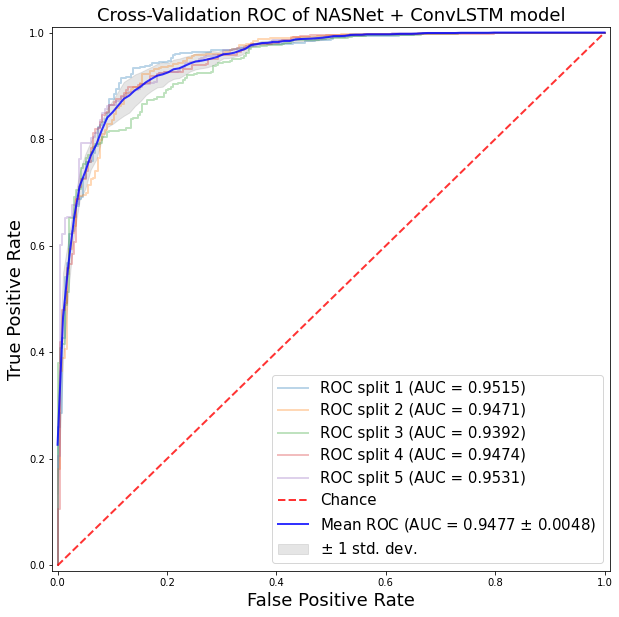

In [ ]:
# Experiment 5: NASNet Mobile + ConvLSTM
runEndToEndExperiment(getLSTMModel, getNasnetModel, 8, '/datarepo/violence-detection-dataset', 'airtlabDataset', 'features', 'filenames.npy', 'labels.npy', 'NASNet + ConvLSTM', 42)